Epoch: 0/900 | Train Acc: 94.19%
Epoch: 100/900 | Train Acc: 98.55%
Epoch: 200/900 | Train Acc: 99.25%
Epoch: 300/900 | Train Acc: 97.43%
Epoch: 400/900 | Train Acc: 99.27%
Epoch: 500/900 | Train Acc: 99.84%
Epoch: 600/900 | Train Acc: 99.46%
Epoch: 700/900 | Train Acc: 99.70%
Epoch: 800/900 | Train Acc: 99.32%
Epoch: 899/900 | Train Acc: 99.49%
Test accuracy: 96.67%


Text(33.0, 0.5, 'True')

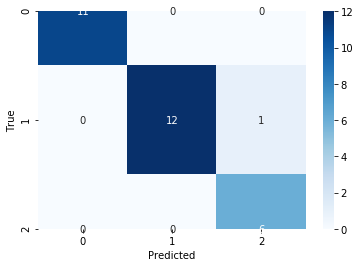

In [183]:
# MLP algorithm with one hidden layer of size 40 taking data from Iris dataset

# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Loading data
iris = load_iris()
X = iris.data
y = iris.target

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scaling data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Training MLP using backpropagation algorithm with layers 4,40,3
class MLP(object):
    # Initializing parameters
    def __init__(self, n_hidden=40, l1=0.0, l2=0.0, epochs=500, eta=0.001, alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1, random_state=None):
        self.random_state = random_state
        self.n_hidden = n_hidden
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.w1, self.w2 = self._initialize_weights()
        self.cost_ = []
    
    # Encoding labels into one-hot representation    
    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot
    
    # Initializing weights
    def _initialize_weights(self):
        rgen = np.random.RandomState(self.random_state)
        w1 = rgen.normal(loc=0.0, scale=0.1, size=(self.n_hidden, X_train_std.shape[1]+1))
        w2 = rgen.normal(loc=0.0, scale=0.1, size=(3, self.n_hidden+1))
        return w1, w2
    
    # Sigmoid function and its derivative
    def _sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-np.clip(z, -250, 250)))
    
    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)
    
    # Adding bias unit to the input layer and the hidden layer 
    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new
    
    # Feedforward propagation 
    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3
    
    # L1 and L2 regularization
    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))
    
    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())
    
    # Cost function and gradient calculation 
    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2) + self._L1_reg(self.l1, w1, w2) + self._L2_reg(self.l2, w1, w2)
        return cost
    
    # Backpropagation algorithm
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # Backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)
        # Regularization and weight updates
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad1[:, 1:] += w1[:, 1:] * self.l2
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += w2[:, 1:] * self.l2
        return grad1, grad2
    
    # Predicting class labels 
    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred
    
    # Training the neural network 
    def fit(self, X_train, y_train, X_valid, y_valid):
        self.cost_ = []
        X_data, y_data = X_train, y_train
        y_enc = self._encode_labels(y_train, 3)
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        for i in range(self.epochs):
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:
                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx], output=a3, w1=self.w1, w2=self.w2)
                self.cost_.append(cost)
                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[:, idx], w1=self.w1, w2=self.w2)
                # update weights
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
                # each 100 epochs calculate and print the loss function and accuracy
            if i%100 == 0 or i == self.epochs-1:
                z2 = self.w1.dot(a1.T)
                a2 = self._sigmoid(z2)
                a2 = self._add_bias_unit(a2, how='row')
                z3 = self.w2.dot(a2)
                a3 = self._sigmoid(z3)
                loss = -np.sum(y_enc[:, idx] * np.log(a3))
                print('Epoch: %d/%d | Train Acc: %.2f%%' % (i, self.epochs, 100 - loss))
            self.eta /= (1 + self.decrease_const*i)
        return self

# Training the neural network
nn = MLP(n_hidden=40, l2=0.01, epochs=900, eta=0.005, alpha=0.001, decrease_const=0.00001, shuffle=True, minibatches=20, random_state=1)
nn.fit(X_train_std, y_train, X_test_std, y_test)

y_test_pred = nn.predict(X_test_std)
acc = (np.sum(y_test == y_test_pred, axis=0)).astype(float) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (acc * 100))

# Showing the matrix of confusion
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
